In [1]:
!pip show torchvision

Name: torchvision
Version: 0.15.1
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /opt/conda/lib/python3.10/site-packages
Requires: numpy, pillow, requests, torch
Required-by: easyocr, fastai, timm


In [2]:
import torch

print(torch.version.cuda) # '11.8' for P100

11.8


In [3]:
!yes y | pip uninstall torch torchvision
!yes y | pip install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu118

Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Would remove:
    /opt/conda/bin/convert-caffe2-to-onnx
    /opt/conda/bin/convert-onnx-to-caffe2
    /opt/conda/bin/torchrun
    /opt/conda/lib/python3.10/site-packages/functorch/*
    /opt/conda/lib/python3.10/site-packages/nvfuser/*
    /opt/conda/lib/python3.10/site-packages/torch-2.0.0.dist-info/*
    /opt/conda/lib/python3.10/site-packages/torch/*
    /opt/conda/lib/python3.10/site-packages/torchgen/*
Proceed (Y/n)?   Successfully uninstalled torch-2.0.0
Found existing installation: torchvision 0.15.1
Uninstalling torchvision-0.15.1:
  Would remove:
    /opt/conda/lib/python3.10/site-packages/torchvision-0.15.1.dist-info/*
    /opt/conda/lib/python3.10/site-packages/torchvision/*
Proceed (Y/n)?   Successfully uninstalled torchvision-0.15.1
yes: standard output: Broken pipe
Looking in indexes: https://download.pytorch.org/whl/nightly/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 GB 348.4 kB/s eta 0:

In [4]:
# Restart kernel after installation:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [5]:
!pip install pycocotools

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 1.3 MB/s eta 0:00:00:00:01


In [1]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
data_folder = Path("/kaggle/input/child-mind-institute-detect-sleep-states")
train_events = pd.read_csv(data_folder/"train_events.csv")
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


In [3]:
series_ids = train_events['series_id'].unique()
len(series_ids)

277

In [4]:
data_prep_folder = Path("/kaggle/input/seb-images-v2")
images_folder = data_prep_folder/"images/images"

In [5]:
image_names = []
for file_path in images_folder.glob("*.jpg"):
    file_name = str(file_path).split("/")[-1]
    image_names.append(file_name)
len(image_names)

7506

In [6]:
image_names[:5]

['2cd2340ca14d_2018-09-10T20_30_00.jpg',
 '0402a003dae9_2018-12-23T20_30_00.jpg',
 '2b8d87addea9_2018-11-16T20_30_00.jpg',
 'ba8083a2c3b8_2019-01-26T20_30_00.jpg',
 'ece2561f07e9_2017-08-18T20_30_00.jpg']

In [7]:
annotations_df = pd.read_csv(data_prep_folder/"SEB_annotations_8_30pm_utc_cutoff.csv")
annotations_df

,series_id,image_name,label,step_in_series,step_in_window,x0,y0,x1,y1
0,038441c925bb,038441c925bb_2018-08-15T20:30:00.jpg,onset,4992.0,4272.0,336,20,376,380
1,038441c925bb,038441c925bb_2018-08-15T20:30:00.jpg,wakeup,10932.0,10212.0,831,20,871,380
2,038441c925bb,038441c925bb_2018-08-16T20:30:00.jpg,onset,20244.0,2244.0,167,20,207,380
3,038441c925bb,038441c925bb_2018-08-16T20:30:00.jpg,wakeup,27492.0,9492.0,771,20,811,380
4,038441c925bb,038441c925bb_2018-08-17T20:30:00.jpg,onset,39996.0,4716.0,373,20,413,380
...,...,...,...,...,...,...,...,...,...
9580,fe90110788d2,fe90110788d2_2017-09-05T20:30:00.jpg,wakeup,547152.0,12192.0,996,20,1036,380
9581,fe90110788d2,fe90110788d2_2017-09-06T20:30:00.jpg,onset,556560.0,4320.0,340,20,380,380
9582,fe90110788d2,fe90110788d2_2017-09-06T20:30:00.jpg,wakeup,560604.0,8364.0,677,20,717,380
9583,fe90110788d2,fe90110788d2_2017-09-07T20:30:00.jpg,onset,574620.0,5100.0,405,20,445,380


In [8]:
len(annotations_df['series_id'].unique())

269

In [9]:
len(annotations_df['image_name'].unique())

4796

In [10]:
window_properties_df = pd.read_csv(data_prep_folder/"SEB_window_properties_8_30pm_utc_cutoff.csv")
window_properties_df

,series_id,image_name,idx_in_series,num_steps_window,num_steps_cumulative
0,038441c925bb,038441c925bb_2018-08-14T20:30:00.jpg,0,720.0,720.0
1,038441c925bb,038441c925bb_2018-08-15T20:30:00.jpg,1,17280.0,18000.0
2,038441c925bb,038441c925bb_2018-08-16T20:30:00.jpg,2,17280.0,35280.0
3,038441c925bb,038441c925bb_2018-08-17T20:30:00.jpg,3,17280.0,52560.0
4,038441c925bb,038441c925bb_2018-08-18T20:30:00.jpg,4,17280.0,69840.0
...,...,...,...,...,...
7501,fe90110788d2,fe90110788d2_2017-09-04T20:30:00.jpg,30,17280.0,534960.0
7502,fe90110788d2,fe90110788d2_2017-09-05T20:30:00.jpg,31,17280.0,552240.0
7503,fe90110788d2,fe90110788d2_2017-09-06T20:30:00.jpg,32,17280.0,569520.0
7504,fe90110788d2,fe90110788d2_2017-09-07T20:30:00.jpg,33,17280.0,586800.0


# train test validation split

In [11]:
file = '/kaggle/input/gamma-train-series-updated-11-11-2023/train_series_10112023.parquet'

DEV = False

series_id  = pd.read_parquet(file, columns=['series_id'])
series_id = series_id.series_id.unique()

print(len(series_id))

if DEV:
    series_id = series_id[::10]

269


In [12]:
from sklearn.model_selection import train_test_split

series_id_train, series_id_test = train_test_split(series_id, 
                                   random_state=1234,  
                                   test_size=0.25,  
                                   shuffle=True)

series_id_val, series_id_test = train_test_split(series_id_test, 
                                   random_state=1234,  
                                   test_size=0.50,  
                                   shuffle=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
series_ids_in_val=series_id_val

In [14]:
len(series_ids_in_val)

34

In [15]:
series_ids_in_train = series_id_train#series_ids[~ np.isin(series_ids, series_ids_in_val)]
series_ids_in_train

array(['27f09a6a858f', '6ee4ade1f2bd', '292a75c0b94e', '280e08693c6d',
       '5c088d7e916c', 'c6788e579967', 'ee4e0e3afd3d', 'b7fc34995d0f',
       '3318a0e3ed6f', '5e816f11f5c3', '60e51cad2ffb', 'c535634d7dcd',
       '361366da569e', 'de6fedfb6139', 'b750c8c1556c', '207eded97727',
       '6d6b9d22d48a', '5c55a5e717d6', 'ccdee561ee5d', 'f88e18cb4100',
       'ce9164297046', '137771d19ca2', 'a596ad0b82aa', '601559e1777d',
       '77ca4db83644', 'bfe41e96d12f', '808652a666c6', '854206f602d0',
       '0d0ad1e77851', '13b4d6a01d27', '3452b878e596', '148471991ffb',
       'a9e5f5314bcb', 'c3072a759efb', '9c91c546e095', '10469f6765bf',
       '844f54dcab89', '0cfc06c129cc', '9fbdeffbe2ba', 'ba8083a2c3b8',
       'b364205aba43', 'e4500e7e19e1', 'e30cb792a2bc', '8877a6586606',
       'a261bc4b7470', 'd515236bdeec', '16fe2798ed0f', 'f2c2436cf7b7',
       'a4e48102f402', 'bf00506437aa', '2cd2340ca14d', 'efbfc4526d58',
       '51b23d177971', 'd2d6b9af0553', 'd0f613c700f7', '3665c86afaf5',
      

In [16]:
len(series_ids_in_train)

201

In [17]:
#series_ids_in_train=annotations_df['series_id'].unique()[0:10]
#series_ids_in_train

In [18]:
#series_ids_in_val=annotations_df['series_id'].unique()[10:15]
#series_ids_in_val

# Now, we need to go from series IDs to image names.

In [19]:
train = window_properties_df.loc[window_properties_df['series_id'].isin(series_ids_in_train)].reset_index(drop=True)
val = window_properties_df.loc[window_properties_df['series_id'].isin(series_ids_in_val)].reset_index(drop=True)
len(train), len(val)

(5479, 987)

# Competition metric

In [20]:
import numpy as np
import pandas as pd
import pandas.api.types
from typing import Dict, List, Tuple

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

In [21]:
def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
        series_id_column_name: str,
        time_column_name: str,
        event_column_name: str,
        score_column_name: str,
        use_scoring_intervals: bool = False,
) -> float:
    """Event Detection Average Precision, an AUCPR metric for event detection in
    time series and video.

    This metric is similar to IOU-threshold average precision metrics commonly
    used in object detection. For events occuring in time series, we replace the
    IOU threshold with a time tolerance.

    Submissions are evaluated on the average precision of detected events,
    averaged over timestamp error tolerance thresholds, averaged over event
    classes.

    Detections are matched to ground-truth events within error tolerances, with
    ambiguities resolved in order of decreasing confidence.

    Detailed Description
    --------------------
    Evaluation proceeds in four steps:

    1. Selection - (optional) Predictions not within a series' scoring
    intervals are dropped.
    2. Assignment - Predicted events are matched with ground-truth events.
    3. Scoring - Each group of predictions is scored against its corresponding
    group of ground-truth events via Average Precision.
    4. Reduction - The multiple AP scores are averaged to produce a single
    overall score.

    Selection

    With each series there may be a defined set of scoring intervals giving the
    intervals of time over which zero or more ground-truth events might be
    annotated in that series. A prediction will be evaluated only if it falls
    within a scoring interval. These scoring intervals can be chosen to improve
    the fairness of evaluation by, for instance, ignoring edge-cases or
    ambiguous events.

    It is recommended that, if used, scoring intervals be provided for training
    data but not test data.

    Assignment

    For each set of predictions and ground-truths within the same `event x
    tolerance x series_id` group, we match each ground-truth to the
    highest-confidence unmatched prediction occurring within the allowed
    tolerance.

    Some ground-truths may not be matched to a prediction and some predictions
    may not be matched to a ground-truth. They will still be accounted for in
    the scoring, however.

    Scoring

    Collecting the events within each `series_id`, we compute an Average
    Precision score for each `event x tolerance` group. The average precision
    score is the area under the (step-wise) precision-recall curve generated by
    decreasing confidence score thresholds over the predictions. In this
    calculation, matched predictions over the threshold are scored as TP and
    unmatched predictions as FP. Unmatched ground-truths are scored as FN.

    Reduction

    The final score is the average of the above AP scores, first averaged over
    tolerance, then over event.

    Parameters
    ----------
    solution : pd.DataFrame, with columns:

        `series_id_column_name` identifier for each time series

        `time_column_name` the time of occurence for each event as a numeric type

        `event_column_name` class label for each event

        The solution contains the time of occurence of one or more types of
        event within one or more time series. The metric expects the solution to
        contain the same event types as those given in `tolerances`.

        When `use_scoring_intervals == True`, you may include `start` and `end`
        events to delimit intervals within which detections will be scored.
        Detected events (from the user submission) outside of these events will
        be ignored.

    submission : pd.DataFrame, with columns as above and in addition:

        `score_column_name` the predicted confidence score for the detected event

    tolerances : Dict[str, List[float]]

        Maps each event class to a list of timestamp tolerances used
        for matching detections to ground-truth events.

    use_scoring_intervals: bool, default False

        Whether to ignore predicted events outside intervals delimited
        by `'start'` and `'end'` events in the solution. When `False`,
        the solution should not include `'start'` and `'end'` events.
        See the examples for illustration.

    Returns
    -------
    event_detection_ap : float
        The mean average precision of the detected events.

    Examples
    --------
    Detecting `'pass'` events in football:
    >>> column_names = {
    ...     'series_id_column_name': 'video_id',
    ...     'time_column_name': 'time',
    ...     'event_column_name': 'event',
    ...     'score_column_name': 'score',
    ... }
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a'],
    ...     'event': ['pass', 'pass'],
    ...     'time': [0, 15],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 10, 14.5],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    Increasing the confidence score of the false detection above the true
    detections decreases the AP.
    >>> submission.loc[1, 'score'] = 1.5
    >>> score(solution, submission, tolerances, **column_names)
    0.6666666666666666...

    Likewise, decreasing the confidence score of a true detection below the
    false detection also decreases the AP.
    >>> submission.loc[1, 'score'] = 0.5  # reset
    >>> submission.loc[0, 'score'] = 0.0
    >>> score(solution, submission, tolerances, **column_names)
    0.8333333333333333...

    We average AP scores over tolerances. Previously, the detection at 14.5
    would match, but adding smaller tolerances gives AP scores where it does
    not match. This results in both a FN, since the ground-truth wasn't
    detected, and a FP, since the detected event matches no ground-truth.
    >>> tolerances = {'pass': [0.1, 0.2, 1.0]}
    >>> score(solution, submission, tolerances, **column_names)
    0.3888888888888888...

    We also average over time series and over event classes.
    >>> tolerances = {'pass': [0.5, 1.0], 'challenge': [0.25, 0.50]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'time': [0, 15, 0],  # restart time for new time series b
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 15, 0],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    By adding scoring intervals to the solution, we may choose to ignore
    detections outside of those intervals.
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a', 'a'],
    ...     'event': ['start', 'pass', 'pass', 'end'],
    ...     'time': [0, 10, 20, 30],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 1.0, 1.0],
    ...     'time': [10, 20, 40],
    ... })
    >>> score(solution, submission, tolerances, **column_names, use_scoring_intervals=True)
    1.0

    """
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
) -> float:

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

# Starts the modelling

In [22]:
def get_transforms():
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    transforms.append(T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
    return T.Compose(transforms)

In [23]:
eval_transforms = get_transforms()
reverse_label_mapping = {1: "onset", 2: "wakeup"}

In [24]:
def compute_metric():
    all_val_preds = []
    for i, series_id in tqdm(enumerate(series_ids_in_val)): # i is the index of the series.
        series_rows = window_properties_df.loc[window_properties_df['series_id'] == series_id].reset_index(drop=True)
        for j in range(len(series_rows)): # j is the index of the image (within the series).
            image_name = series_rows['image_name'][j]
            image_path = os.path.join(data_prep_folder, "images/images", image_name)
            image_path = image_path.replace(":", "_")
            image = read_image(image_path)
            with torch.no_grad():
                x = eval_transforms(image)
                x = x.to(device)
                predictions = model([x])
            pred = predictions[0]
            # Postprocessing: remove 'narrow' boxes as these are false positives.
            pred_widths = pred['boxes'][:, 2] - pred['boxes'][:, 0]
            pred['boxes'] = pred['boxes'][pred_widths > 10]
            pred['labels'] = pred['labels'][pred_widths > 10]
            pred['scores'] = pred['scores'][pred_widths > 10]
            if len(pred['labels']) == 0:
                continue
            else:
                pred_x = (pred['boxes'][:, 0] + pred['boxes'][:, 2]) / 2
                pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
                num_steps_window = series_rows['num_steps_window'][j]
                if j == 0:
                    prev_num_steps_cumulative = 0
                else:
                    prev_num_steps_cumulative = series_rows['num_steps_cumulative'][j - 1]            
                for k in range(len(pred_labels)): # k is the index of the bounding box (within the image).
                    event = {}
                    step_in_window = (pred_x[k] / 1440) * num_steps_window # All images have width 1,440px.
                    step_in_series = int(prev_num_steps_cumulative + step_in_window)
                    event['series_id'] = series_id
                    event['step'] = step_in_series
                    event['event'] = pred_labels[k]
                    event['score'] = pred['scores'][k].item()
                    all_val_preds.append(event)
    all_val_preds_df = pd.DataFrame(all_val_preds)
    all_val_preds_df = all_val_preds_df.sort_values(by=['series_id', 'step']).reset_index(drop=True)
    all_val_preds_df['row_id'] = np.arange(len(all_val_preds_df))
    all_val_preds_df = all_val_preds_df[['row_id', 'series_id', 'step', 'event', 'score']]
    competition_metric = round(score(val_events, all_val_preds_df, tolerances, **column_names), 4)
    return competition_metric

# Creating a custom Dataset class

In [25]:
class SleepStatesDataset(torch.utils.data.Dataset):
    def __init__(self, split_df, annotations_df, images_folder, transforms):
        self.label_mapping = {'onset': 1, 'wakeup': 2}
        self.split_df = split_df
        self.annotations_df = annotations_df
        self.images_folder = images_folder
        self.transforms = transforms
    
    def __len__(self):
        return len(self.split_df)
    
    def __getitem__(self, idx):
        image_name = self.split_df['image_name'][idx]
        image_path = os.path.join(self.images_folder, image_name)
        image_path = image_path.replace(":", "_")
        #print(image_name)
        #print(image_path)
        image = read_image(image_path)
        window_df = self.annotations_df.loc[self.annotations_df['image_name'] == image_name]
        if len(window_df) > 0:            
            boxes = torch.tensor(window_df.iloc[:, 5:].values, dtype=torch.float32)
            labels = window_df['label']
            labels = torch.tensor([self.label_mapping[l] for l in labels], dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros(size=(len(window_df),), dtype=torch.int64)
        else:
            boxes = torch.empty(size=(0, 4), dtype=torch.float32)
            labels = torch.empty(size=(0,), dtype=torch.int64)
            area = torch.empty(size=(0,), dtype=torch.float32)
            iscrowd = torch.empty(size=(0,), dtype=torch.int64)
        
        image = tv_tensors.Image(image)
        target = {}
        target['image_id'] = image_name
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

# Let's test whether our SleepStatesDataset class works.

In [26]:
train_dataset = SleepStatesDataset(train, annotations_df, images_folder, get_transforms())
val_dataset = SleepStatesDataset(val, annotations_df, images_folder, get_transforms())

In [27]:
len(train_dataset), len(val_dataset)

(5479, 987)

In [28]:
train_dataset[1]

(tensor([[[ 2.2489,  2.2489,  2.2489,  ..., -1.7240, -1.5014,  1.4612],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.2557,  1.2385,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.1633,  2.1462],
          ...,
          [ 1.3927, -1.5699, -1.7069,  ..., -0.4739, -1.7925, -2.0323],
          [ 1.7865, -0.4226, -1.8097,  ..., -1.9638, -2.1179, -2.1179],
          [ 1.9235,  1.1872, -2.1179,  ..., -1.6384, -2.1179, -2.1179]],
 
         [[ 2.4111,  2.4286,  2.4286,  ..., -1.8431, -1.6506,  1.3782],
          [ 2.4111,  2.4111,  2.4286,  ...,  1.2381,  1.1856,  2.2185],
          [ 2.4111,  2.4111,  2.4286,  ...,  2.3060,  2.2010,  2.1660],
          ...,
          [ 2.1485, -0.5301,  0.0301,  ...,  0.7829,  0.1001,  0.2227],
          [ 2.4286,  0.7654,  0.1702,  ..., -0.1800,  0.0126,  0.4678],
          [ 2.4286,  2.4286, -0.0224,  ...,  0.4503,  0.2227,  0.2402]],
 
         [[ 2.6400,  2.6400,  2.6400,  ..., -0.3578,  0.0605,  2.6400],
          [ 2.6400,  2.6400,

# Instantiating the model & data loaders

In [29]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1234) # 42

In [30]:
# Load an object detection model pre-trained on COCO:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", max_size=1440)
# Replace the classifier with a new one, that has num_classes which is user-defined:
num_classes = 3 # 2 classes ('onset' & 'wakeup') + the 'background' class
# Get the number of input features for the box classifier:
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the pre-trained box predictor head with a new one:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 159MB/s]  


In [31]:
# Download helper functions:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")

--2023-11-22 13:05:18--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23628 (23K) [text/plain]
Saving to: ‘transforms.py’

     0K .......... .......... ...                             100% 35.2M=0.001s

2023-11-22 13:05:18 (35.2 MB/s) - ‘transforms.py’ saved [23628/23628]

--2023-11-22 13:05:18--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) 

0

In [32]:
import utils # utils.py

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8,
                                           shuffle=True, num_workers=4,
                                           collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8,
                                         shuffle=False, num_workers=4,
                                         collate_fn=utils.collate_fn)
len(train_loader), len(val_loader)

(685, 124)

# Let's test our model's forward pass on a single batch.

In [34]:
images, targets = next(iter(val_loader))
type(images), type(targets)

(tuple, tuple)

In [35]:
images = [image for image in images]
targets = [target for target in targets]
output = model(images, targets)
output

{'loss_classifier': tensor(2.0055, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0039, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(2.0943, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.2448, grad_fn=<DivBackward0>)}

# Training

In [36]:
from engine import train_one_epoch, evaluate # engine.py

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [38]:
#model_idx = "seb_model_v1_"
#num_epochs = 5
#for epoch in range(num_epochs):
   # # Train for one epoch:
   # train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)
   # # Note: The above function modifies the model in-place.
   # # Update the learning rate at the end of each epoch:
   # lr_scheduler.step()
   # # Evaluate on the validation set:
   # evaluate(model, val_loader, device=device)
   # # Compute the competition metric:
   # competition_metric = compute_metric()
   # print(f"Competition metric: {competition_metric}")
   # print("Saving model weights...")
   # torch.save(model.state_dict(), f"{model_idx}_{epoch}.pth")
   # print("Model weights saved.")
    #print("---")
#print("That's it!")

# Examining a few validation set predictions

In [39]:
#model.load_state_dict(torch.load("/kaggle/working/seb_model_v1__4.pth"))
#model.eval();

In [40]:
model.load_state_dict(torch.load("/kaggle/input/seb-train-cnn-models-image-detection/seb_model_v1__4.pth"))
model.eval();

# Examining a couple of randomly selected images that have exactly 2 annotations

In [41]:
annotations_per_image = annotations_df.groupby('image_name').size()
annotations_per_image

image_name
038441c925bb_2018-08-15T20:30:00.jpg    2
038441c925bb_2018-08-16T20:30:00.jpg    2
038441c925bb_2018-08-17T20:30:00.jpg    2
038441c925bb_2018-08-18T20:30:00.jpg    2
038441c925bb_2018-08-20T20:30:00.jpg    2
                                       ..
fe90110788d2_2017-09-03T20:30:00.jpg    2
fe90110788d2_2017-09-04T20:30:00.jpg    2
fe90110788d2_2017-09-05T20:30:00.jpg    2
fe90110788d2_2017-09-06T20:30:00.jpg    2
fe90110788d2_2017-09-07T20:30:00.jpg    2
Length: 4796, dtype: int64

In [42]:
exactly_2_annotations = annotations_per_image.loc[annotations_per_image == 2]
exactly_2_annotations

image_name
038441c925bb_2018-08-15T20:30:00.jpg    2
038441c925bb_2018-08-16T20:30:00.jpg    2
038441c925bb_2018-08-17T20:30:00.jpg    2
038441c925bb_2018-08-18T20:30:00.jpg    2
038441c925bb_2018-08-20T20:30:00.jpg    2
                                       ..
fe90110788d2_2017-09-03T20:30:00.jpg    2
fe90110788d2_2017-09-04T20:30:00.jpg    2
fe90110788d2_2017-09-05T20:30:00.jpg    2
fe90110788d2_2017-09-06T20:30:00.jpg    2
fe90110788d2_2017-09-07T20:30:00.jpg    2
Length: 4779, dtype: int64

In [43]:
val_exactly_2_annotations = val.loc[val['image_name'].isin(exactly_2_annotations.index)].reset_index(drop=True)
val_exactly_2_annotations

,series_id,image_name,idx_in_series,num_steps_window,num_steps_cumulative
0,062dbd4c95e6,062dbd4c95e6_2018-08-23T20:30:00.jpg,1,17280.0,20340.0
1,062dbd4c95e6,062dbd4c95e6_2018-08-26T20:30:00.jpg,4,17280.0,72180.0
2,062dbd4c95e6,062dbd4c95e6_2018-08-27T20:30:00.jpg,5,17280.0,89460.0
3,062dbd4c95e6,062dbd4c95e6_2018-08-28T20:30:00.jpg,6,17280.0,106740.0
4,062dbd4c95e6,062dbd4c95e6_2018-08-31T20:30:00.jpg,9,17280.0,158580.0
...,...,...,...,...,...
674,fcca183903b7,fcca183903b7_2019-04-26T20:30:00.jpg,31,17280.0,538200.0
675,fcca183903b7,fcca183903b7_2019-04-27T20:30:00.jpg,32,17280.0,555480.0
676,fcca183903b7,fcca183903b7_2019-04-28T20:30:00.jpg,33,17280.0,572760.0
677,fcca183903b7,fcca183903b7_2019-04-29T20:30:00.jpg,34,17280.0,590040.0


In [44]:
np.random.seed(42)
idxs = np.random.randint(low=0, high=954, size=2)
idxs

array([102, 435])

In [45]:
#'b7188813d58a_2018-10-11T20:30:00.jpg' -- interesante!

image_name = val_exactly_2_annotations['image_name'][idxs[1]]
image_name = '137b99e936ab_2018-07-25T20:30:00.jpg'

image_path = os.path.join(data_prep_folder, "images/images", image_name)
image_path = image_path.replace(":", "_")
image = read_image(image_path)
window = annotations_df.loc[annotations_df['image_name'] == image_name].reset_index(drop=True)
window['x'] = (window['x0'] + window['x1']) / 2

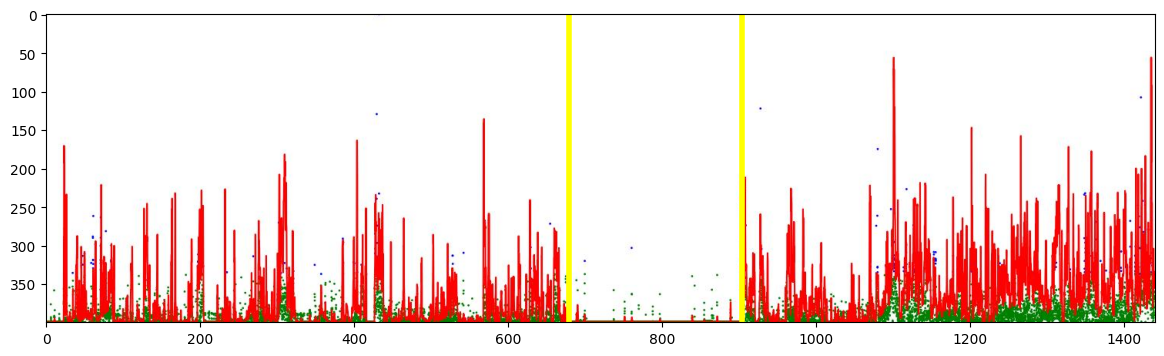

In [46]:
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(image.permute(1, 2, 0));

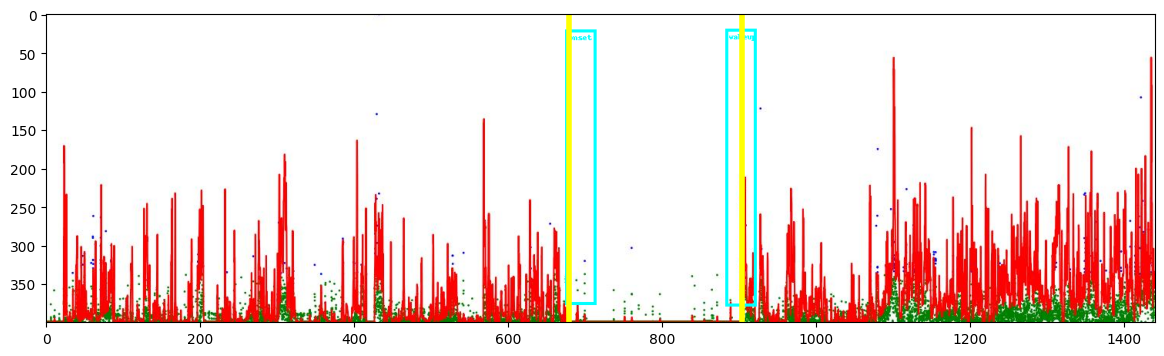

In [47]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
    
thresh = 0.7
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="cyan", width=4)
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(output_image.permute(1, 2, 0));

In [56]:
#'b7188813d58a_2018-10-11T20:30:00.jpg' -- interesante!

image_name = val_exactly_2_annotations['image_name'][idxs[1]]
image_name = '72bbd1ac3edf_2017-10-08T20:30:00.jpg'

image_path = os.path.join(data_prep_folder, "images/images", image_name)
image_path = image_path.replace(":", "_")
image = read_image(image_path)
window = annotations_df.loc[annotations_df['image_name'] == image_name].reset_index(drop=True)
window['x'] = (window['x0'] + window['x1']) / 2

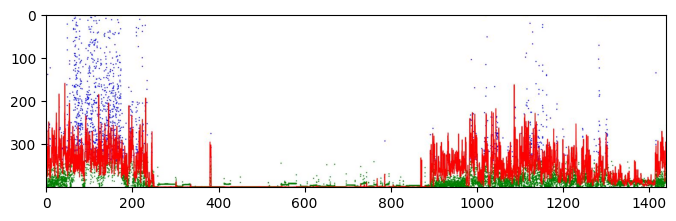

In [61]:
plt.figure(figsize=(8, 4))
#plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(image.permute(1, 2, 0));

In [67]:
window

,series_id,image_name,label,step_in_series,step_in_window,x0,y0,x1,y1,x
0,72bbd1ac3edf,72bbd1ac3edf_2017-10-08T20:30:00.jpg,onset,316884.0,3144.0,242,20,282,380,262.0
1,72bbd1ac3edf,72bbd1ac3edf_2017-10-08T20:30:00.jpg,wakeup,324396.0,10656.0,868,20,908,380,888.0


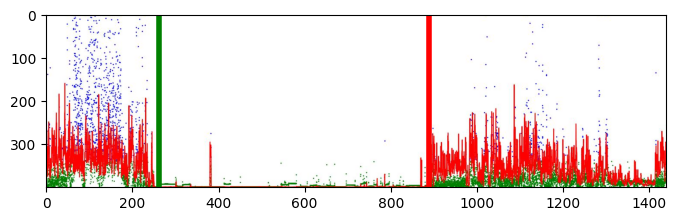

In [65]:
plt.figure(figsize=(8, 4))
plt.vlines(x=window['x'][0], ymin=0, ymax=400, colors="g", linewidth=4)
plt.vlines(x=window['x'][1], ymin=0, ymax=400, colors="r", linewidth=4)
plt.imshow(image.permute(1, 2, 0));

In [90]:
boxes_2

tensor([[868.,  20., 908., 380.]])

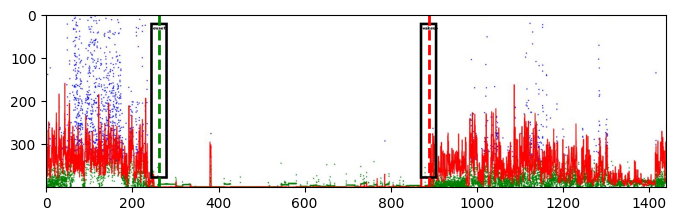

In [96]:
boxes = torch.tensor(window.iloc[:, 5:9].values, dtype=torch.float32)
output_image = draw_bounding_boxes(image, boxes, pred_labels, colors="black", width=6)
plt.figure(figsize=(8, 4))
plt.vlines(x=window['x'][0], ymin=0, ymax=400, colors="g", linewidth=2, linestyle="dashed")
plt.vlines(x=window['x'][1], ymin=0, ymax=400, colors="r", linewidth=2, linestyle="dashed")
#plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(output_image.permute(1, 2, 0));

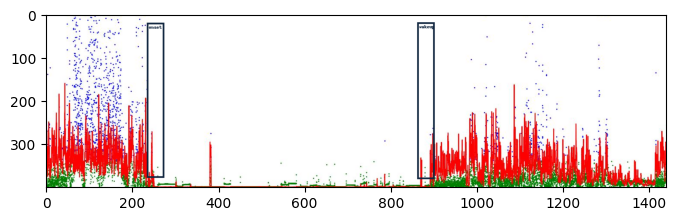

In [98]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
    
thresh = 0.7
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="#122740", width=4)
plt.figure(figsize=(8, 4))
#plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(output_image.permute(1, 2, 0));

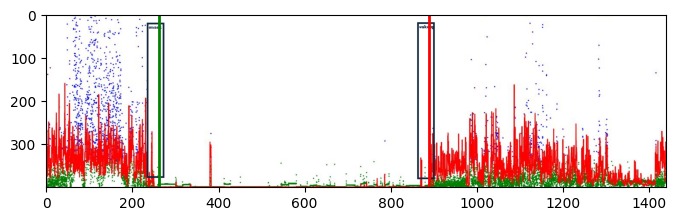

In [99]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
    
thresh = 0.7
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="#122740", width=4)
plt.figure(figsize=(8, 4))
plt.vlines(x=window['x'][0], ymin=0, ymax=400, colors="g", linewidth=2)
plt.vlines(x=window['x'][1], ymin=0, ymax=400, colors="r", linewidth=2)
plt.imshow(output_image.permute(1, 2, 0));

In [108]:
window['step_in_window'][0]

3144.0

In [117]:
window

,series_id,image_name,label,step_in_series,step_in_window,x0,y0,x1,y1,x
0,72bbd1ac3edf,72bbd1ac3edf_2017-10-08T20:30:00.jpg,onset,316884.0,3144.0,242,20,282,380,262.0
1,72bbd1ac3edf,72bbd1ac3edf_2017-10-08T20:30:00.jpg,wakeup,324396.0,10656.0,868,20,908,380,888.0


In [111]:
pred_x = (pred['boxes'][:, 0] + pred['boxes'][:, 2]) / 2
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
num_steps_window=window['step_in_window'][0]
step_in_window_l1 = (pred_x[0] / 1440) * num_steps_window
num_steps_window=window['step_in_window'][1]
step_in_window_l2 = (pred_x[1] / 1440) * num_steps_window

In [116]:
pred_x

tensor([254.1929, 882.5746], device='cuda:0')

In [113]:
step_in_window_l1.item()

554.98779296875

In [115]:
step_in_window_l2.item()

6531.0517578125

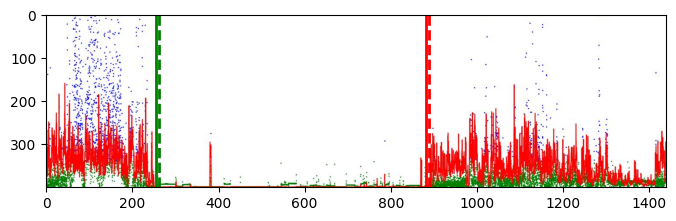

In [123]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
    
thresh = 0.7
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
#output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="#122740", width=4)
plt.figure(figsize=(8, 4))
plt.vlines(x=window['x'][0], ymin=0, ymax=400, colors="g", linewidth=2, linestyle="dashed")
plt.vlines(x=window['x'][1], ymin=0, ymax=400, colors="r", linewidth=2, linestyle="dashed")
plt.vlines(x=pred_x[0].item(), ymin=0, ymax=400, colors="g", linewidth=2)
plt.vlines(x=pred_x[1].item(), ymin=0, ymax=400, colors="r", linewidth=2)
plt.imshow(image.permute(1, 2, 0));

In [69]:
pred_boxes

tensor([[234,  20, 274, 378],
        [862,  19, 902, 381]], device='cuda:0')

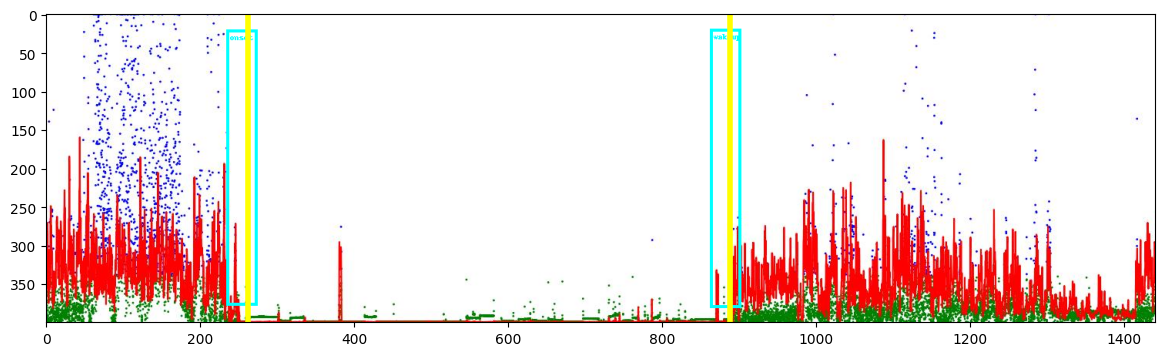

In [51]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
    
thresh = 0.7
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="cyan", width=4)
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(output_image.permute(1, 2, 0));

In [52]:
#'b7188813d58a_2018-10-11T20:30:00.jpg' -- interesante!

image_name = val_exactly_2_annotations['image_name'][idxs[1]]
image_name = 'efbfc4526d58_2018-12-21T20:30:00.jpg'

image_path = os.path.join(data_prep_folder, "images/images", image_name)
image_path = image_path.replace(":", "_")
image = read_image(image_path)
window = annotations_df.loc[annotations_df['image_name'] == image_name].reset_index(drop=True)
window['x'] = (window['x0'] + window['x1']) / 2

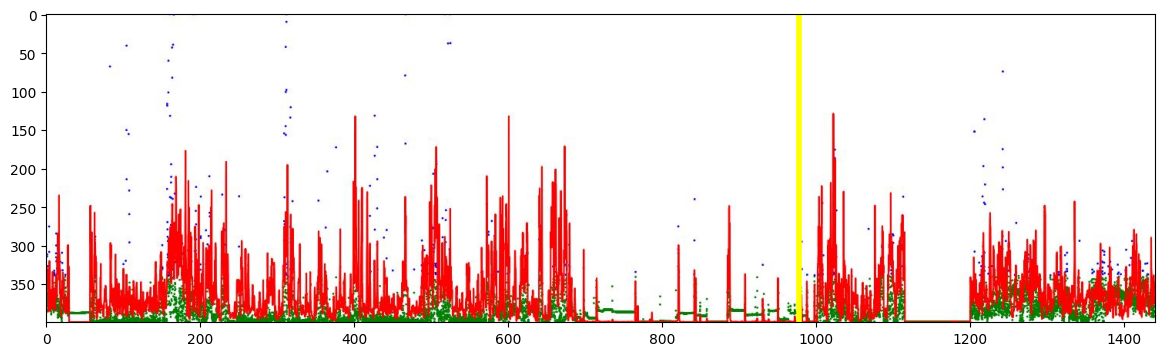

In [53]:
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(image.permute(1, 2, 0));

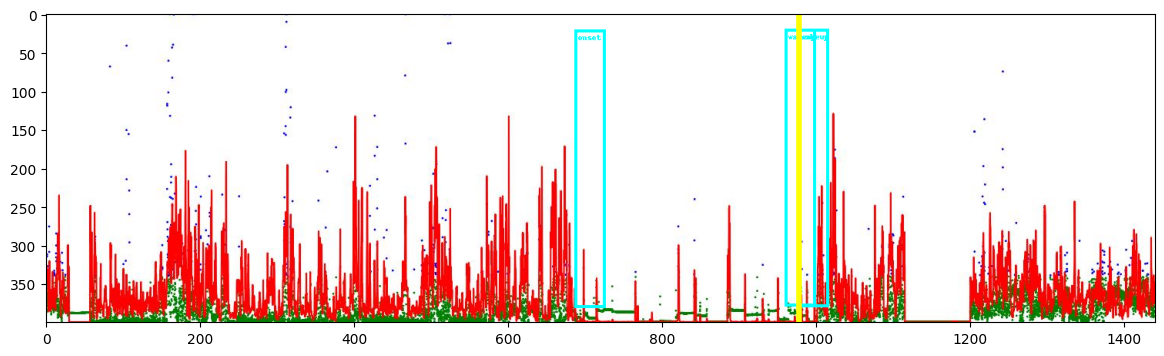

In [54]:
with torch.no_grad():
    x = eval_transforms(image)
    x = x.to(device)
    predictions = model([x])
    
thresh = 0.7
pred = predictions[0]
pred['boxes'] = pred['boxes'][pred['scores'] > thresh]
pred['labels'] = pred['labels'][pred['scores'] > thresh]
pred['scores'] = pred['scores'][pred['scores'] > thresh]
pred_boxes = pred['boxes'].long()
pred_labels = [reverse_label_mapping[l.item()] for l in pred['labels']]
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="cyan", width=4)
plt.figure(figsize=(14.4, 4))
plt.vlines(x=window['x'], ymin=0, ymax=400, colors="yellow", linewidth=4)
plt.imshow(output_image.permute(1, 2, 0));